In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the dataset
df = shuffled_df

# Define the category mapping
category_mapping = {'AC': 0, 'PC': 1, 'TC': 2, 'NC': 3}
df['category_int'] = df['category'].map(category_mapping)

# Split into train-test
X_train, X_test, y_train, y_test = train_test_split(df['response'], df['category_int'], test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to the same length
max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader
batch_size = 16
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

# Model setup
vocab_size = 5000
embed_dim = 100
hidden_dim = 128
output_dim = 4  # Number of categories

model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, output_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for texts, labels in test_loader:
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct / total:.4f}")

# Example prediction
def predict(text):
    text_seq = tokenizer.texts_to_sequences([text])
    text_pad = pad_sequences(text_seq, maxlen=max_len)
    text_tensor = torch.tensor(text_pad, dtype=torch.long).to(device)
    model.eval()
    with torch.no_grad():
        output = model(text_tensor)
        _, pred = torch.max(output, 1)
    return pred.item()

print(f"Example Prediction: {predict('I am nervous about the exam')}")


Epoch 1, Loss: 0.7290
Epoch 2, Loss: 0.6072
Epoch 3, Loss: 0.5655
Epoch 4, Loss: 0.5428
Epoch 5, Loss: 0.5240
Test Accuracy: 0.7793
Example Prediction: 0


In [ ]:
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_filters, filter_sizes, output_dim):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embed_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_dim)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # (batch, 1, sentence_length, embed_dim)
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [torch.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        return self.fc(x)

# Model setup
model = CNNTextClassifier(vocab_size, embed_dim=100, num_filters=100, filter_sizes=[3,4,5], output_dim=4)
model.to(device)


CNNTextClassifier(
  (embedding): Embedding(5000, 100)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=4, bias=True)
)

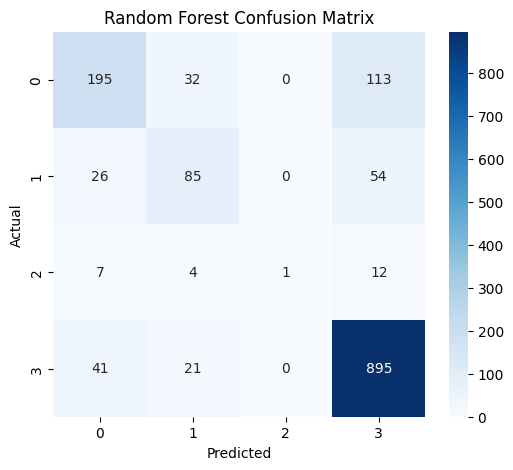

Epoch 1, Loss: 0.7335, Acc: 0.7182
Epoch 2, Loss: 0.6097, Acc: 0.7785
Epoch 3, Loss: 0.5649, Acc: 0.7944
Epoch 4, Loss: 0.5410, Acc: 0.8042
Epoch 5, Loss: 0.5250, Acc: 0.8104


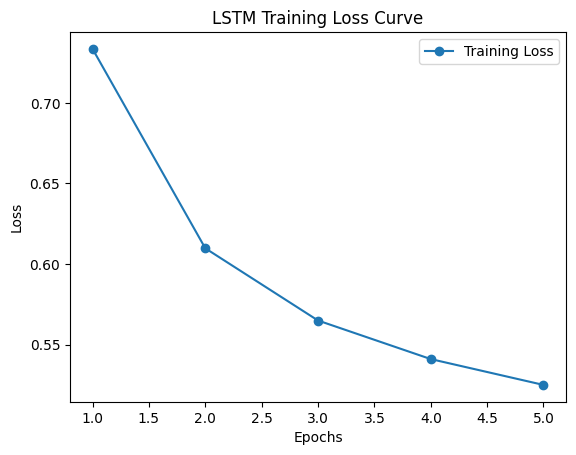

Epoch 1, Loss: 1.2722, Acc: 0.3290
Epoch 2, Loss: 1.2728, Acc: 0.3290
Epoch 3, Loss: 1.2726, Acc: 0.3290
Epoch 4, Loss: 1.2722, Acc: 0.3290
Epoch 5, Loss: 1.2728, Acc: 0.3290


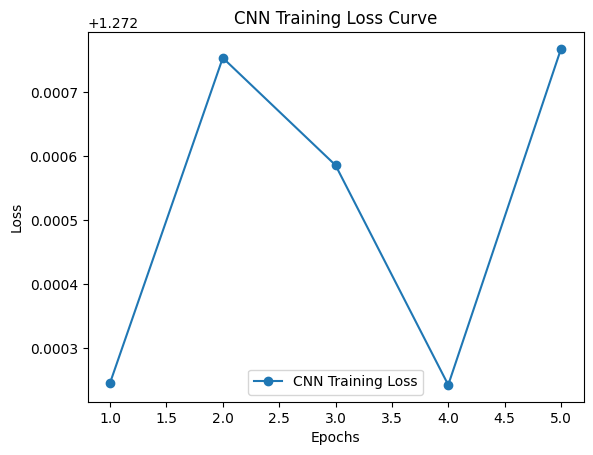

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from torch.utils.data import DataLoader, TensorDataset

# Load dataset (Assuming shuffled_df is already available)
df = shuffled_df
category_mapping = {'AC': 0, 'PC': 1, 'TC': 2, 'NC': 3}
df['category_int'] = df['category'].map(category_mapping)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['response'], df['category_int'], test_size=0.2, random_state=42)

# 1️⃣ TF-IDF + Random Forest
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

# Confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

# 2️⃣ LSTM Model
vocab_size = 5000
embed_dim = 100
max_len = 100

# Tokenize & pad sequences
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# Convert to tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=16, shuffle=False)

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

model = LSTMClassifier(vocab_size, embed_dim, 128, 4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

losses, accuracies = [], []
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    losses.append(total_loss / len(train_loader))
    accuracies.append(correct / total)
    print(f"Epoch {epoch+1}, Loss: {losses[-1]:.4f}, Acc: {accuracies[-1]:.4f}")

# Plot loss curve
plt.plot(range(1, num_epochs+1), losses, marker='o', label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Training Loss Curve")
plt.legend()
plt.show()

# 3️⃣ CNN Model
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_filters, filter_sizes, output_dim):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embed_dim)) for fs in filter_sizes
        ])
        self.fc = nn.Linear(num_filters * len(filter_sizes), output_dim)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [torch.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        return self.fc(x)

model_cnn = CNNTextClassifier(vocab_size, 100, 100, [3,4,5], 4).to(device)

# Train CNN model
losses_cnn, accuracies_cnn = [], []
for epoch in range(num_epochs):
    model_cnn.train()
    total_loss, correct, total = 0, 0, 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_cnn(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    losses_cnn.append(total_loss / len(train_loader))
    accuracies_cnn.append(correct / total)
    print(f"Epoch {epoch+1}, Loss: {losses_cnn[-1]:.4f}, Acc: {accuracies_cnn[-1]:.4f}")

plt.plot(range(1, num_epochs+1), losses_cnn, marker='o', label='CNN Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN Training Loss Curve")
plt.legend()
plt.show()
